In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

## Working in relative coordinates for particles 1 and 2:
## (This makes PN corrections easier)
### $\mathbf{a} = \mathbf{a}_1 - \mathbf{a}_2$
### $\mathbf{r} = \mathbf{r}_1 - \mathbf{r}_2=(r_x,r_y)$
### $\mathbf{n} = \mathbf{r}/r = \mathbf{n}_{12} = -\mathbf{n}_{21}$


## EOM:
### (Chapter 9 of ``Gravity: Newtonian, Post-Newtonian, Relativistic'', Poisson & Will)
\begin{equation}
\begin{split}
\mathbf{a} = \mathbf{r}''(t) = &-\frac{ G m }{r^2 (t)} \mathbf{n}(t)  \\
&-  \frac{Gm}{c^2 r^2 } \Bigg( \Big( v^2 (1+3\eta) - \frac{3}{2} (\mathbf{n} \cdot \mathbf{v})^2 \eta - 2(2+\eta) \frac{Gm}{r} \Big) \mathbf{n} \\
& \hspace{2cm}  - 2 (2-\eta) (\mathbf{n} \cdot \mathbf{v})  \mathbf{v} \Bigg) \\
& \ + \mathcal{O} \Big( \frac{1}{c^{4}} \Big)
\end{split}
\end{equation}


with: $m = M_1  + M_2$ , and  $\ \ \eta = (M_1 M_2) / (M_1  + M_2)^2$
### $r_x''(t) = a_{0} + a_{1} + a_{2} + a_{3} + a_{4}$
### $a_0(t) = -\frac{ G m }{(r_x^2 + r_y^2)^{3/2}} r_x $
### $a_1(t) = -\frac{ G m }{c^2 (r_x^2 + r_y^2)^{3/2}}r_x (v_x^2 + v_y^2) ( 1 + 3 \eta) $
### $a_2(t) = +\frac{3}{2}\frac{ G m }{c^2 (r_x^2 + r_y^2)^{5/2}}r_x (r_x v_x + r_y v_y)^2 \eta $
### $a_3(t) = +2\frac{ (G m)^2 }{c^2 (r_x^2 + r_y^2)^{4/2}}r_x ( 2 + \eta) $
### $a_4(t) = +2\frac{ G m }{c^2 (r_x^2 + r_y^2)^{3/2}}( 2 -\eta)(r_x v_x + r_y v_y) v_x$


## For Python : $y = r_x, r_y, r_x', r_y' =r_x, r_y, v_x, v_y$

In [29]:
def a0_component(r_x, r_y, Gm):
    return -Gm*r_x* ((r_x*r_x +r_y*r_y)**(-1.5))

def a1_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    v_squared = v_x*v_x +v_y*v_y
    eta_factor = 1 + 3*eta
    return -Gm*r_x* ((r_x*r_x +r_y*r_y)**(-1.5)) * v_squared * eta_factor / c_squared

def total_relative_a(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    return a0_component(r_x, r_y, Gm) + a1_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta)

def relative_dynamics(y,t,Gm, c_squared, eta):
    r_x, r_y, v_x, v_y = y
    dydt = [v_x,
            v_y,
            total_relative_a(r_x, r_y, v_x, v_y, Gm, c_squared, eta),
            total_relative_a(r_y, r_x, v_y, v_x, Gm, c_squared, eta)]
    return dydt

In [73]:
y0 = [-1, 1, .1, 0.5]
Gm_val = 1
c_squared_val = 2e2
eta_val = 1e-2 
t = np.linspace(0, 10, 401)

In [74]:
sol_non_rel = odeint(relative_dynamics, y0, t, args=(Gm_val, c_squared_val*1e5, eta_val,))
sol = odeint(relative_dynamics, y0, t, args=(Gm_val, c_squared_val, eta_val,))

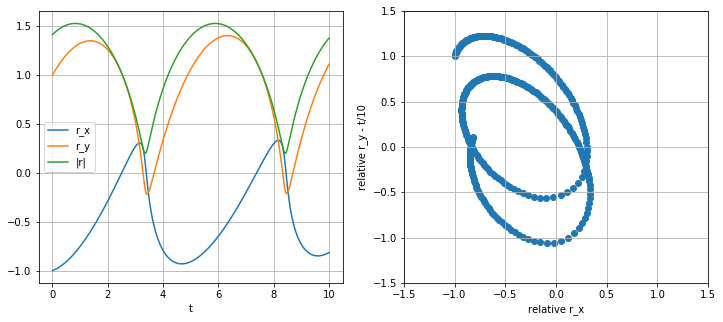

In [75]:
_ = plt.figure(figsize=(12,5)), plt.subplot(1,2,1)
_ = plt.plot(t, sol[:, 0], label='r_x')
_ = plt.plot(t, sol[:, 1], label='r_y')
_ = plt.plot(t, np.sqrt(sol[:, 0]**2.+sol[:, 1]**2.), label='|r|')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.subplot(1,2,2), plt.ylim(-1.5,1.5), plt.xlim(-1.5,1.5)
_ = plt.scatter(sol[:, 0], sol[:, 1] - t/10.)
_ = plt.ylabel('relative r_y - t/10'), plt.xlabel('relative r_x'), plt.grid()

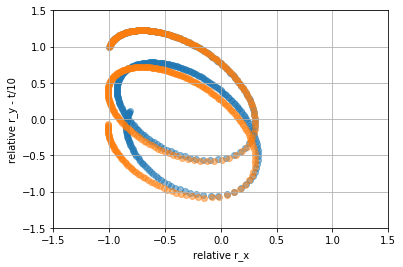

In [76]:
_ = plt.ylim(-1.5,1.5), plt.xlim(-1.5,1.5)
_ = plt.scatter(sol[:, 0], sol[:, 1] - t/10., alpha=0.5)
_ = plt.scatter(sol_non_rel[:, 0], sol_non_rel[:, 1] - t/10., alpha=0.5)
_ = plt.ylabel('relative r_y - t/10'), plt.xlabel('relative r_x'), plt.grid()

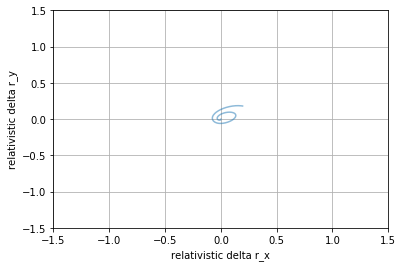

In [79]:
_ = plt.ylim(-1.5,1.5), plt.xlim(-1.5,1.5)
_ = plt.plot(sol[:, 0] - sol_non_rel[:, 0], sol[:, 1]- sol_non_rel[:, 1], alpha=0.5)
_ = plt.ylabel('relativistic delta r_y'), plt.xlabel('relativistic delta r_x'), plt.grid()

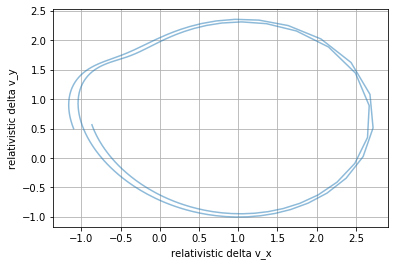

In [81]:
_ = plt.plot(sol[:, 0] - sol_non_rel[:, 2], sol[:, 1]- sol_non_rel[:, 3], alpha=0.5)
_ = plt.ylabel('relativistic delta v_y'), plt.xlabel('relativistic delta v_x'), plt.grid()